In [26]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones

In [25]:
def radian_to_degree(rad):
    return np.degrees(rad)

In [24]:
#Function to split the training data into X,y datasets
def load_dataset_deg(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data\\2023_14_11"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns

    #Converts from rad to degrees the columns
    for column in increments_df.columns:
        increments_df[column] = increments_df[column].apply(radian_to_degree)

    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns

    #Converts from rad to degrees the columns
    for column in prev_j_positions_df.columns:
        prev_j_positions_df[column] = prev_j_positions_df[column].apply(radian_to_degree)

    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns

    #Converts from rad to degrees the columns
    for column in post_j_positions_df.columns:
        post_j_positions_df[column] = post_j_positions_df[column].apply(radian_to_degree)

    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [23]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a"):
    # Defining usefull variables
    path = os.getcwd() + "\\training_data\\2023_14_11"
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [22]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"],
                X_a["increments_0"], X_a["increments_1"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [21]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  #plt.ylim([0,0.1])
  plt.legend()
  plt.show()

In [ ]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1)

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [15]:
def export_model(exp_scene, exp_model, exp_scaler):
    timestr = time.strftime("_%Y_%d_%m")
    models_path = "models\\" + timestr[1:]
    if not os.path.exists(models_path):
        os.mkdir(models_path)
        print(f"Directorio '{models_path}' ha sido creado.")
    else:
        print(f"El directorio '{models_path}' ya existe.")
    exp_model.save(models_path + "\\model_" + exp_scene + timestr + ".keras")
    with open(models_path + "\\scaler_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_scaler, file)

### Modular 02b

In [29]:
scene = "modular02b"
X, y =load_dataset(scene)
X, y = adapt_X_y(X,y)
X

,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint0_actions_rad,joint1_actions_rad
0,-0.143837,-0.000049,0.075768,0.785398,0.822049,-0.063003,0.129370
1,0.020225,-0.000987,0.049226,0.722072,0.952162,-0.101401,0.115712
2,0.017572,-0.000656,0.051854,0.619943,1.069076,0.124915,0.080963
3,0.015315,-0.000785,0.053130,0.744681,1.151542,0.027373,0.046843
4,0.013768,-0.000662,0.054070,0.772048,1.199990,-0.068754,0.083295
...,...,...,...,...,...,...,...
34995,-0.196537,-0.005244,0.011115,-0.919729,1.462700,-0.044939,0.122721
34996,-0.212267,-0.006065,0.003583,-0.964621,1.570844,-0.005056,-0.060318
34997,-0.212601,-0.005989,0.007733,-0.969641,1.512710,-0.038094,0.060632
34998,-0.223104,-0.007487,0.003578,-1.007712,1.570921,-0.014367,-0.063969


In [30]:
y

,future_state_x,future_state_y,future_state_z,joint0_future_state_rad,joint1_future_state_rad
0,0.020225,-0.000987,0.049226,0.722072,0.952162
1,0.017572,-0.000656,0.051854,0.619943,1.069076
2,0.015315,-0.000785,0.053130,0.744681,1.151542
3,0.013768,-0.000662,0.054070,0.772048,1.199990
4,0.011616,0.000373,0.054994,0.702999,1.285014
...,...,...,...,...,...
34995,-0.212267,-0.006065,0.003583,-0.964621,1.570844
34996,-0.212601,-0.005989,0.007733,-0.969641,1.512710
34997,-0.223104,-0.007487,0.003578,-1.007712,1.570921
34998,-0.223605,-0.007907,0.007958,-1.022118,1.509475


In [33]:
maxim = max(y.iloc[:,-1])*180/math.pi
maxim

90.02234405325328

In [34]:
minim = min(y.iloc[:,-1])*180/math.pi
minim

-90.03141454447106

In [35]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape, y_train.shape

((28000, 7), (28000, 5))

In [36]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(28000, 7)

In [37]:
# Creacion y entrenamiento del modelo
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=7, input_dim=7, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=24, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=5, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
700/700 [==============================] - 2s 1ms/step - loss: 0.0379 - val_loss: 0.0014
Epoch 2/25
700/700 [==============================] - 1s 1ms/step - loss: 4.7645e-04 - val_loss: 1.7412e-04
Epoch 3/25
700/700 [==============================] - 1s 1ms/step - loss: 1.0222e-04 - val_loss: 7.0822e-05
Epoch 4/25
700/700 [==============================] - 1s 1ms/step - loss: 6.1535e-05 - val_loss: 6.6207e-05
Epoch 5/25
700/700 [==============================] - 1s 1ms/step - loss: 5.4651e-05 - val_loss: 5.6327e-05
Epoch 6/25
700/700 [==============================] - 1s 1ms/step - loss: 5.0190e-05 - val_loss: 4.9444e-05
Epoch 7/25
700/700 [==============================] - 1s 1ms/step - loss: 4.7547e-05 - val_loss: 4.7546e-05
Epoch 8/25
700/700 [==============================] - 1s 1ms/step - loss: 4.6691e-05 - val_loss: 5.1906e-05
Epoch 9/25
700/700 [==============================] - 1s 1ms/step - loss: 4.4884e-05 - val_loss: 4.4957e-05
Epoch 10/25
700/700 [===============

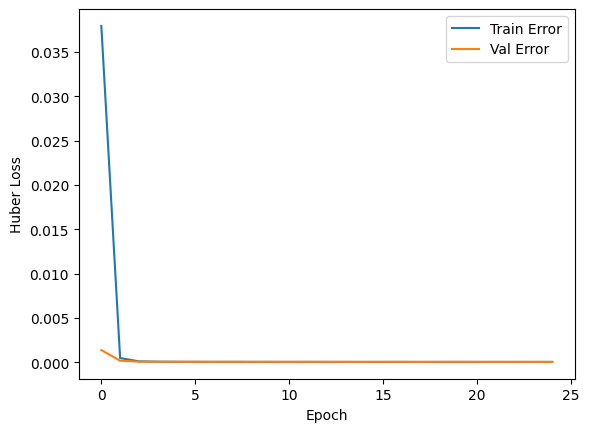

In [38]:
plot_history(history, "Huber")

In [39]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

219/219 [==============================] - 0s 815us/step


Los valores maximos predichos

In [40]:
maxim = max(df_test_predictions.iloc[:,-1])
max_i = df_test_predictions[4].tolist().index(maxim)
prev_max = X_test.iloc[max_i]["joint1_current_state_rad"]
act_max = X_test.iloc[max_i]["joint1_actions_rad"]

minim = min(df_test_predictions.iloc[:,-1])
min_i = df_test_predictions[4].tolist().index(minim)
prev_min = X_test.iloc[min_i]["joint1_current_state_rad"]
act_min = X_test.iloc[min_i]["joint1_actions_rad"]


print(f"Indice {max_i} valor maximo {maxim*180/math.pi} grad y {maxim} rad, estado previo {prev_max*180/math.pi} y accion {act_max*180/math.pi}")
print(f"Indice {min_i} valor minimo {minim*180/math.pi} grad y {minim} rad, estado previo {prev_min*180/math.pi} y accion {act_min*180/math.pi}")

Indice 4169 valor maximo 97.34890356081837 grad y 1.6990588903427124 rad, estado previo 89.99781001375459 y accion 7.494429884161711
Indice 40 valor minimo -96.35326005531644 grad y -1.6816816329956055 rad, estado previo -89.999995674289 y accion -6.011419878451067


In [41]:
# Pone el mismo nombre a las columnas de las predicciones a las salidas
df_test_predictions.columns = y_test.columns

,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.053245,-0.377749,0.000068,0.015868
1,future_state_y,0.027414,-0.024720,0.000015,0.029396
2,future_state_z,0.143754,0.000253,0.000040,0.028017
3,joint0_future_state_rad,1.571629,-1.570949,0.000122,0.003871
4,joint1_future_state_rad,1.571153,-1.571100,0.000108,0.003430


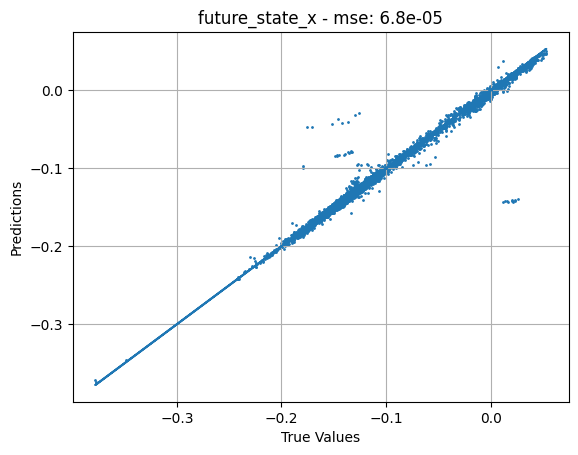

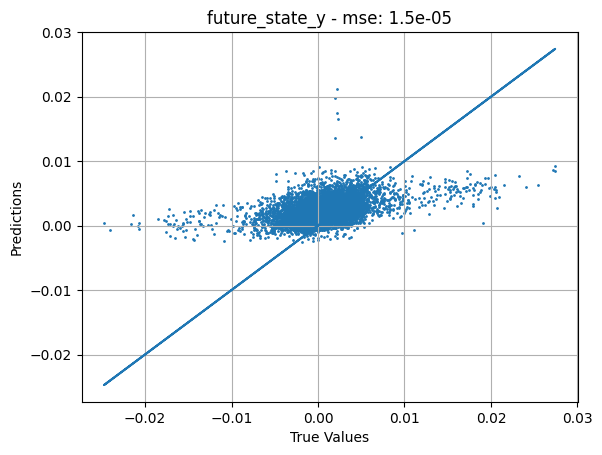

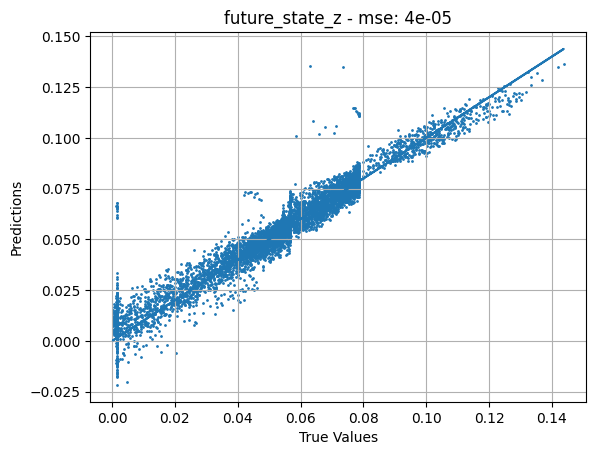

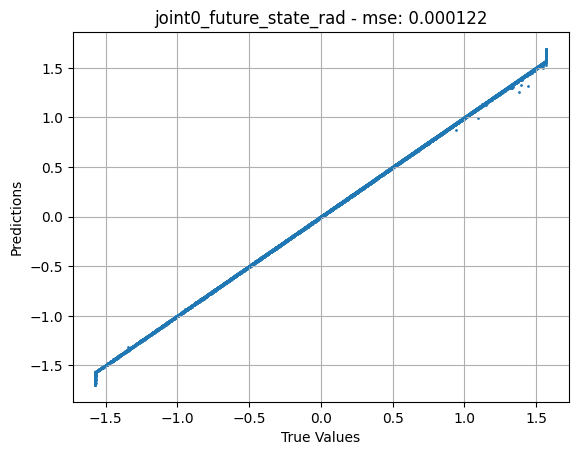

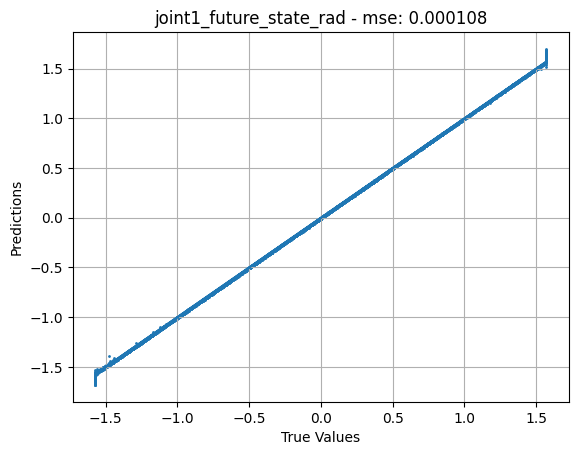

In [42]:
plot_pred_vs_test(y_test, df_test_predictions)

In [43]:
timestr = time.strftime("_%Y_%d_%m")
models_path = "models\\" + timestr[1:]
if not os.path.exists(models_path):
    os.mkdir(models_path)
    print(f"Directorio '{models_path}' ha sido creado.")
else:
    print(f"El directorio '{models_path}' ya existe.")
model.save(models_path + "\\model_" + scene + timestr + ".keras")
with open(models_path + "\\scaler_" + scene + timestr + '.pkl', 'wb') as file:
    pickle.dump(scaler, file)

El directorio 'models\2023_14_11' ya existe.


### Datos de entrenamiento

In [44]:
scene = "modular02_"
path = os.getcwd() + "\\training_data\\2023_14_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]

print(scene_files_list[0])

file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

joined_training_dataset_modular02_2023_14_11_1024.pkl


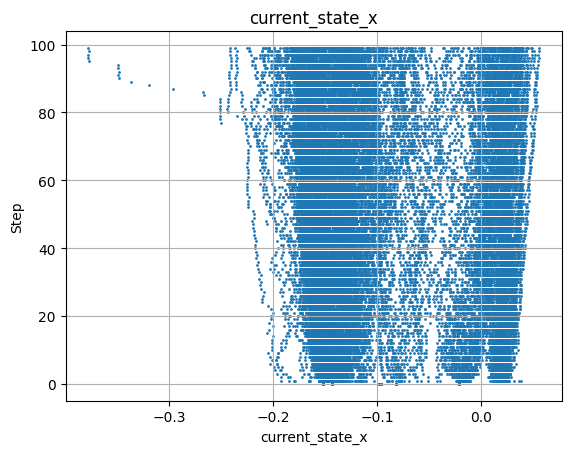

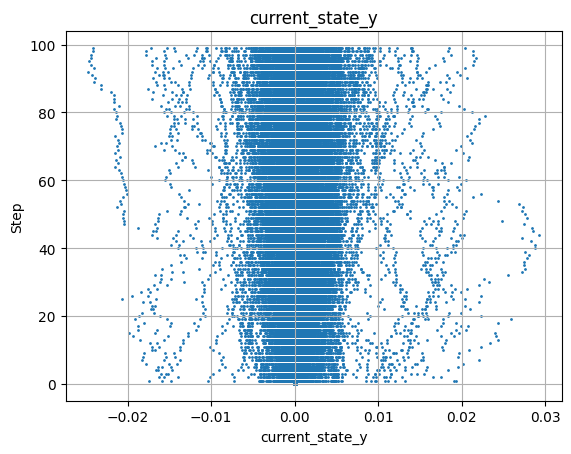

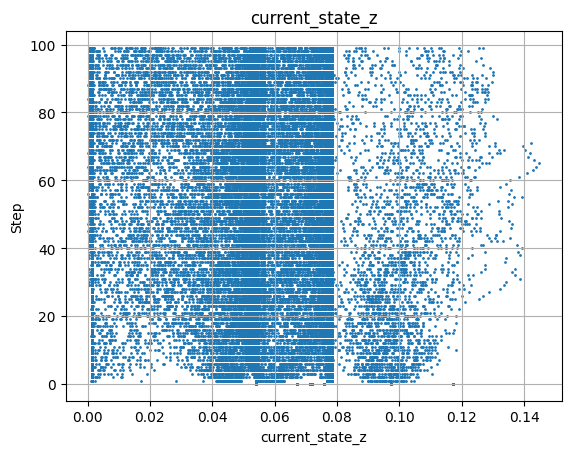

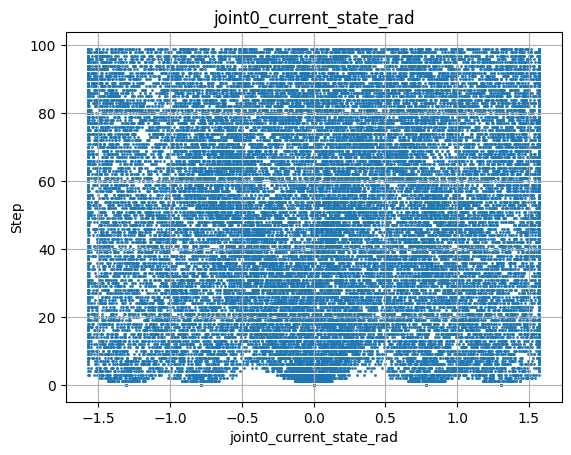

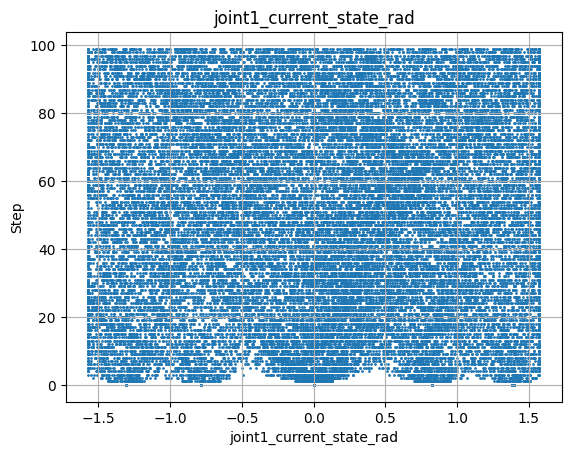

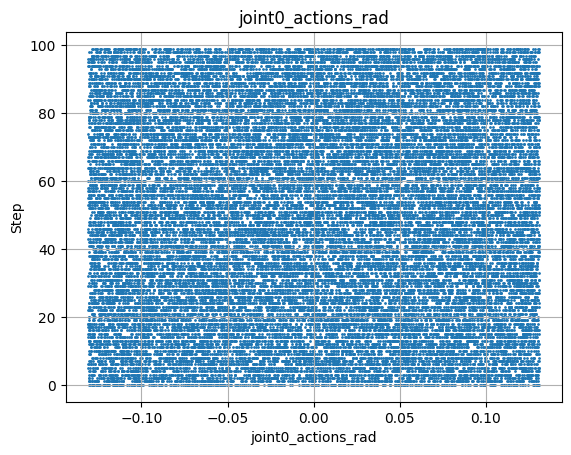

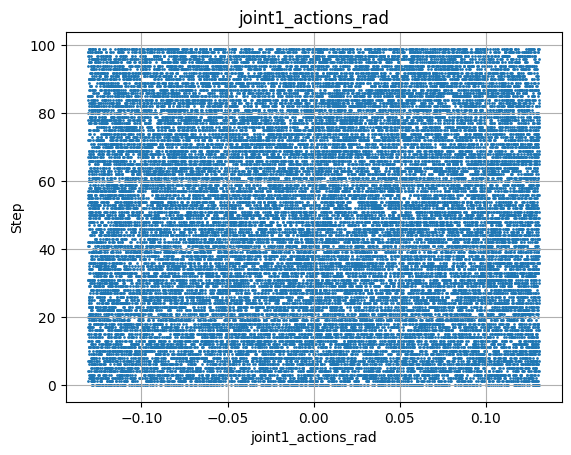

In [45]:
## Se grafica la tabla de valores de entrenamiento para ver que tanto varian y si se tiene el rango necesario para la base.
columns = X_train.columns.tolist()
for col in range(-7,0):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1], s=1)
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    #plt.xlim(-1,1)
    plt.grid()

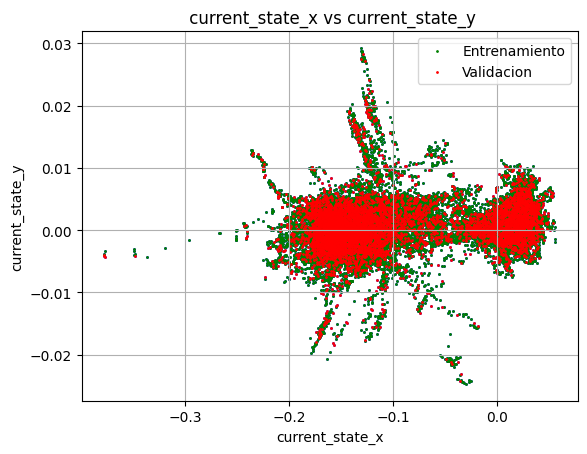

In [53]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-7],X.iloc[:,-6], s=1, color='blue')
plt.scatter(X_train.iloc[:,-7],X_train.iloc[:,-6], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-7],X_test.iloc[:,-6], s=1, color='red', label='Validacion')
plt.title(f" {columns[-7]} vs {columns[-6]}")
plt.ylabel(columns[-6])
plt.xlabel(columns[-7])
plt.legend()
plt.grid()

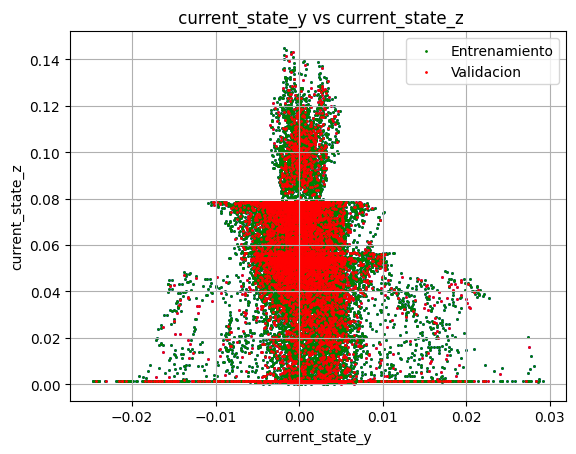

In [52]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,-6],X.iloc[:,-5], s=1, color='blue')
plt.scatter(X_train.iloc[:,-6],X_train.iloc[:,-5], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,-6],X_test.iloc[:,-5], s=1, color='red', label='Validacion')
plt.title(f" {columns[-6]} vs {columns[-5]}")
plt.ylabel(columns[-5])
plt.xlabel(columns[-6])
plt.legend()
plt.grid()

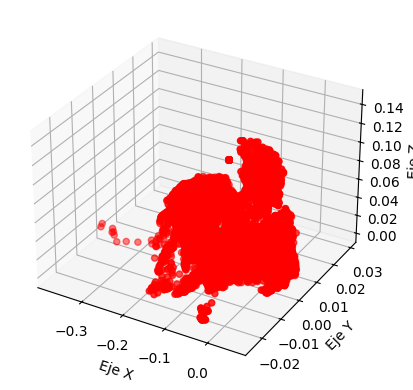

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de ejemplo
x = X_train.iloc[:,-7]
y = X_train.iloc[:,-6]
z = X_train.iloc[:,-5]

# Crear una figura en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(x, y, z, c='r', marker='o')

# Etiquetas de ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar la gráfica en 3D
plt.show()

Se grafica para cada posicion del joint las acciones

In [47]:
X_train.columns.tolist()

['current_state_x',
 'current_state_y',
 'current_state_z',
 'joint0_current_state_rad',
 'joint1_current_state_rad',
 'joint0_actions_rad',
 'joint1_actions_rad']

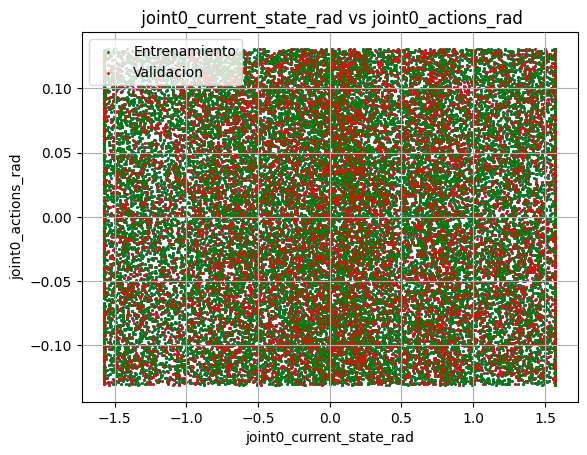

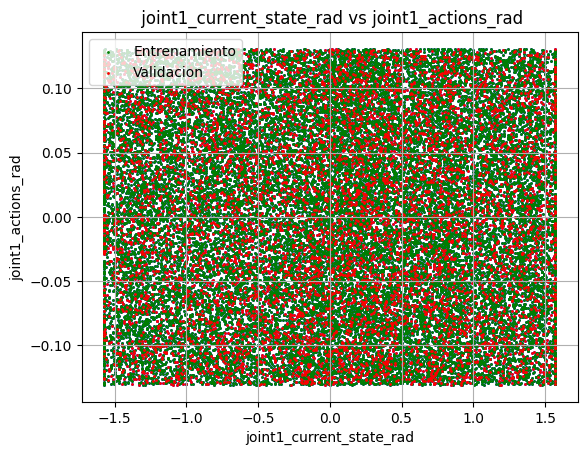

In [48]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=1, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=1, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()